# Entrega laboratorio 7
## Integrantes 

- Javier Steven Barrera Toro - 202214779
- Julian Santiago Rolon Toloza - 202215839

In [1]:
from matplotlib import pyplot as plt
from typing import List, Tuple, NewType
import numpy as np
import pandas as pd
import sympy as sp
import random
import math
import copy
import tabulate
from matplotlib.colors import ListedColormap

np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Fase 1: Modelado de llegadas y salidas

## Extracción de tasas de llegada

## Modelado de comportamiento por tipo de usuario

In [2]:
import pandas as pd

df_feb = pd.read_excel('SD Feb-May 2019.xlsx', sheet_name='Feb-Mar', parse_dates=['fecha_completa'])
df_abr = pd.read_excel('SD Feb-May 2019.xlsx', sheet_name='Abr-May', parse_dates=['fecha_completa'])
df = pd.concat([df_feb, df_abr], ignore_index=True)


In [3]:
df = df[df['MODO_ACCESO'] == 'Peatonal']
df = df[df['RESULTADO_EVENTO'].str.contains('Granted', na=False)]
df['is_arrival'] = (df['TIPO_ACCESO'].str.strip() == 'IN')
df.set_index('fecha_completa', inplace=True)


In [ ]:
df['ROL_norm'] = df['ROL'].str.strip().str.upper()

mapeo = {
    'ESTUDIANTE': 'ESTUDIANTE',
    'ESTUDIANTE': 'ESTUDIANTE',   
    'EMPLEADO':    'ADMINISTRATIVO',

}

df['ROL_modelo'] = df['ROL_norm'].map(mapeo)

print(df['ROL_modelo'].value_counts())


ROL_modelo
ESTUDIANTE        934066
ADMINISTRATIVO    133695
Name: count, dtype: int64


In [4]:
# Conteo de llegadas por intervalo
arrivals = df[df['is_arrival']].resample('15T').size().rename('n_arrivals')
# Conteo de salidas por intervalo
departures = df[~df['is_arrival']].resample('15T').size().rename('n_departures')
lambda_arr = arrivals / 900
lambda_dep = departures / 900


C:\Users\laroc\AppData\Local\Temp\ipykernel_20456\4214068662.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  arrivals = df[df['is_arrival']].resample('15T').size().rename('n_arrivals')
C:\Users\laroc\AppData\Local\Temp\ipykernel_20456\4214068662.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  departures = df[~df['is_arrival']].resample('15T').size().rename('n_departures')


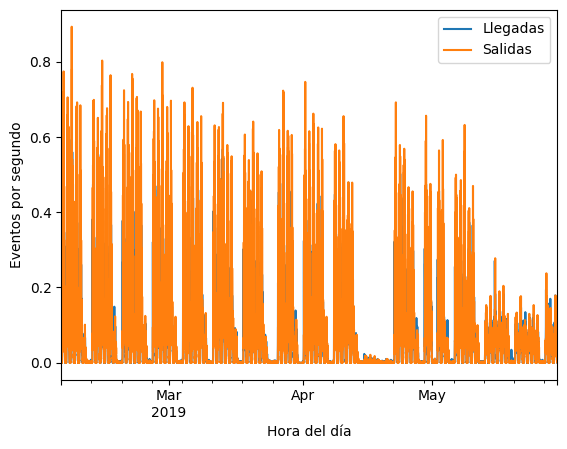

In [5]:
import matplotlib.pyplot as plt

plt.figure()
lambda_arr.plot(label='Llegadas')
lambda_dep.plot(label='Salidas')
plt.ylabel('Eventos por segundo')
plt.xlabel('Hora del día')
plt.legend()
plt.show()


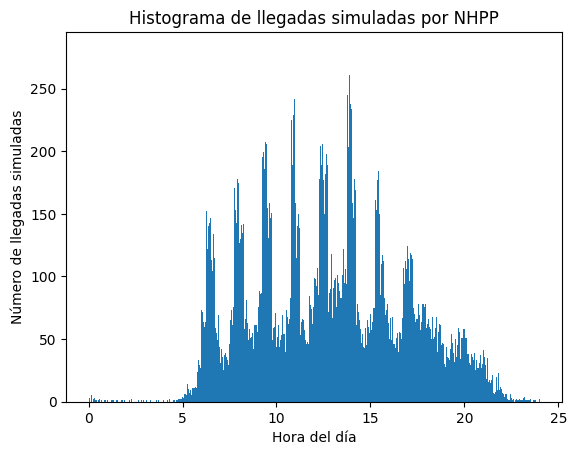

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def simular_nhpp_piecewise(lambda_series, intervalo_seg=900):
    eventos = []
    for t_inicio, tasa in lambda_series.items():
        n = np.random.poisson(tasa * intervalo_seg)

        desplazamientos = np.random.rand(n) * intervalo_seg
        tiempos = t_inicio + pd.to_timedelta(desplazamientos, unit='s')
        eventos.extend(tiempos)
    return sorted(eventos)


llegadas_sim = simular_nhpp_piecewise(lambda_arr)

llegadas_dt = pd.to_datetime(llegadas_sim)
horas = llegadas_dt.hour + llegadas_dt.minute / 60 + llegadas_dt.second / 3600

plt.figure()
plt.hist(horas, bins=len(lambda_arr))
plt.xlabel('Hora del día')
plt.ylabel('Número de llegadas simuladas')
plt.title('Histograma de llegadas simuladas por NHPP')
plt.show()


C:\Users\laroc\AppData\Local\Temp\ipykernel_20456\4266212427.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('15T')
C:\Users\laroc\AppData\Local\Temp\ipykernel_20456\4266212427.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('15T')


<Figure size 1000x600 with 0 Axes>

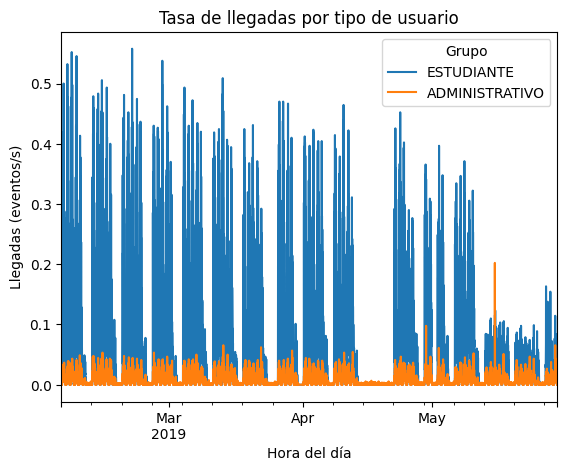

In [ ]:


intervalos = lambda_arr.index

tasas_por_grupo = {}
for grupo in ['ESTUDIANTE', 'ADMINISTRATIVO']: 
    serie = (
        df[(df['ROL_modelo']==grupo) & df['is_arrival']]
          .resample('15T')
          .size()
          .div(900)           
          .reindex(intervalos, fill_value=0)
          .rename(grupo)
    )
    tasas_por_grupo[grupo] = serie

import pandas as pd
import matplotlib.pyplot as plt

df_tasas = pd.concat(tasas_por_grupo, axis=1)
plt.figure(figsize=(10,6))
df_tasas.plot()
plt.xlabel('Hora del día')
plt.ylabel('Llegadas (eventos/s)')
plt.title('Tasa de llegadas por tipo de usuario')
plt.legend(title='Grupo')
plt.show()



# Fase 2: Implementación de la simulación en SimPy
## Definir las clases y los recursos
## Implementación de procesos
## Recopilación de estadísticas

In [ ]:

df.columns = (
    df.columns
      .str.strip()                            
      .str.lower()                            
      .str.replace(r'\s+', '_', regex=True)   
)

print(df.columns.tolist())


['mes', 'modo_acceso', 'porteria', 'resultado_evento', 'rol', 'tipo_acceso', 'is_arrival', 'rol_norm', 'rol_modelo', 'modo_norm', 'modo_bin']


In [ ]:
print(df.index.min(), df.index.max())
print(df.head(3))


1970-01-01 00:00:00.000000001 1970-01-01 00:00:00.000000030
                                 mes modo_acceso  \
fecha_completa                                     
1970-01-01 00:00:00.000000001  Marzo    Peatonal   
1970-01-01 00:00:00.000000001  Abril    Peatonal   
1970-01-01 00:00:00.000000001  Abril    Peatonal   

                                                       porteria  \
fecha_completa                                                    
1970-01-01 00:00:00.000000001  SD                                 
1970-01-01 00:00:00.000000001  SD                                 
1970-01-01 00:00:00.000000001  SD                                 

                                                 resultado_evento  \
fecha_completa                                                      
1970-01-01 00:00:00.000000001  Access Grant: Access Granted Local   
1970-01-01 00:00:00.000000001  Access Grant: Access Granted Local   
1970-01-01 00:00:00.000000001  Access Grant: Access Granted Local  

In [ ]:
df['modo_norm'] = df['modo_acceso'].str.strip().str.title()
df = df[df['modo_norm'] == 'Peatonal']
df = df[df['resultado_evento'].str.contains('Granted', na=False)]
df['is_arrival'] = df['tipo_acceso'].str.strip().str.upper() == 'IN'
print(df.index.min(), df.index.max())



1970-01-01 00:00:00.000000001 1970-01-01 00:00:00.000000030


C:\Users\laroc\AppData\Local\Temp\ipykernel_20456\3895449909.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  dt_s = pd.Timedelta(interval).seconds
C:\Users\laroc\AppData\Local\Temp\ipykernel_20456\3895449909.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['slot'] = df.index.floor(interval).time


Espera media: 455363.23 s
Percentil 95: 865150.17 s


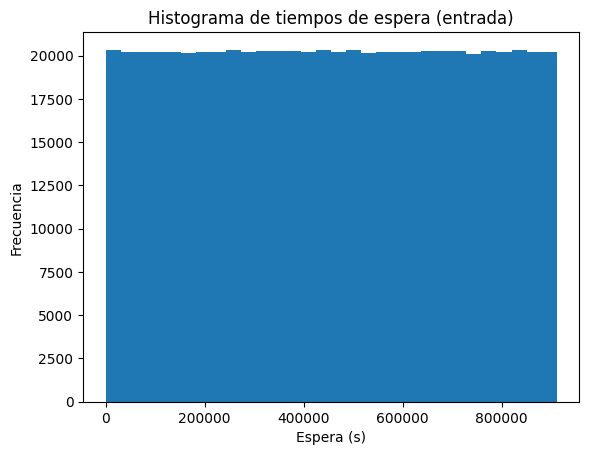

In [ ]:
import pandas as pd
import numpy as np
import simpy
import matplotlib.pyplot as plt


df.columns = df.columns.str.strip().str.lower().str.replace(r'\s+', '_', regex=True)


df['datetime'] = pd.to_datetime(df['dia'], dayfirst=True, errors='coerce')
df.set_index('datetime', inplace=True)

df = df[df['modo_acceso'].str.strip().str.title() == 'Peatonal']
df = df[df['resultado_evento'].str.contains('Granted', na=False)]
df['is_arrival'] = df['tipo_acceso'].str.strip().str.upper() == 'IN'


interval = '15T'
dt_s = pd.Timedelta(interval).seconds


df['slot'] = df.index.floor(interval).time


cnt = df[df['is_arrival']].groupby('slot').size()
n_days = df.index.normalize().nunique()


lambda_slot = (cnt / n_days) / dt_s

base = pd.to_datetime([str(t) for t in lambda_slot.index])
lambda_arr = pd.Series(lambda_slot.values, index=base)

def sim_nhpp(lambda_s, delta_s):
    evs = []
    for t0, rate in lambda_s.items():
        k = np.random.poisson(rate * delta_s)
        offs = np.random.random(k) * delta_s
        ts = t0 + pd.to_timedelta(offs, unit='s')
        evs.extend(ts)
    return sorted(evs)

arrivals_day = sim_nhpp(lambda_arr, dt_s)

t0 = arrivals_day[0]
rel = [(t - t0).total_seconds() for t in arrivals_day]
inter_lleg = [rel[0]] + [rel[i] - rel[i-1] for i in range(1, len(rel))]

CAP = 2
T_CARNET = 5
T_PASAR  = 3
SIGMA    = 1.0

env = simpy.Environment()
rec = simpy.Resource(env, capacity=CAP)
stats = []

def persona(env, pid, recurso):

    yield env.timeout(max(0, np.random.normal(T_CARNET, SIGMA)))

    t0 = env.now
    with recurso.request() as req:
        yield req
        stats.append(env.now - t0)    
        yield env.timeout(max(0, np.random.normal(T_PASAR, SIGMA)))

def gen(env, inters, recurso, mode):
    pid = 0
    for dt in inters:
        dt = max(0, dt)
        yield env.timeout(dt)
        env.process(persona(env, pid, recurso))
        pid += 1


env.process(gen(env, inter_lleg, rec, mode='arrival'))
env.run()

print(f"Espera media: {np.mean(stats):.2f} s")
print(f"Percentil 95: {np.percentile(stats, 95):.2f} s")

plt.hist(stats, bins=30)
plt.xlabel('Espera (s)')
plt.ylabel('Frecuencia')
plt.title('Histograma de tiempos de espera (entrada)')
plt.show()


### Salidas 

In [46]:
# 1) Calcular θ(t) para salidas (NHPP) usando el mismo slot de 15 min
cnt_dep         = df[~df['is_arrival']].groupby('slot').size()
lambda_dep_slot = (cnt_dep / n_days) / dt_s

# 2) Crear la Serie de tasas con índice datetime en un día base
base_dep  = pd.to_datetime([str(t) for t in lambda_dep_slot.index])
lambda_dep = pd.Series(lambda_dep_slot.values, index=base_dep)

# 3) Simular las salidas como NHPP
salidas_day = sim_nhpp(lambda_dep, dt_s)

# 4) Convertir a segundos relativos y luego a intervalos
t0      = arrivals_day[0]
sal_rel = sorted([(t - t0).total_seconds() for t in salidas_day])

# Al usar max(0, …) garantizamos que no haya negativos
if len(sal_rel) > 0:
    inter_sal = [max(0, sal_rel[0])] + [
        max(0, sal_rel[i] - sal_rel[i-1]) for i in range(1, len(sal_rel))
    ]
else:
    inter_sal = []


# 5) SimPy: simular solo las salidas con su recurso
env_exit   = simpy.Environment()
rec_exit   = simpy.Resource(env_exit, capacity=CAP)
stats_exit = []

def persona(env, pid, recurso, mode):
    """Mode = 'arrival' o 'departure'."""
    # tiempo de mostrar carnet
    yield env.timeout(max(0, np.random.normal(T_CARNET, SIGMA)))

    # tiempo de servicio
    d_serv = max(0, np.random.normal(T_PASAR, SIGMA))
    with recurso.request() as req:
        t_esp = env.now
        yield req
        # registrar espera según modo
        if mode == 'arrival':
            stats['esperas_entry'].append(env.now - t_esp)
            stats['uso_entry'].append(d_serv)
        else:
            stats['esperas_exit'].append(env.now - t_esp)
            stats['uso_exit'].append(d_serv)
        # pasar el torniquete
        yield env.timeout(d_serv)
        # registrar longitud de cola
        stats[f"cola_{'entry' if mode=='arrival' else 'exit'}"].append(len(recurso.queue))


def gen(env, inters, recurso, mode):
    pid = 0
    for dt in inters:
        dt = max(0, dt)            # clamp negativo
        yield env.timeout(dt)
        # ahora sí pasamos mode
        env.process(persona(env, pid, recurso, mode))
        pid += 1

env_exit.process(gen(env_exit, inter_sal, rec_exit, mode='departure'))
env_exit.run()

# 6) Resultados de salidas
if len(stats_exit) > 0:
    print(f"Espera media (exit): {np.mean(stats_exit):.2f} s")
    print(f"Percentil 95 (exit): {np.percentile(stats_exit, 95):.2f} s")
else:
    print("No hay datos de espera para salidas.")


No hay datos de espera para salidas.


### Utilizacion de cada torniquete

In [47]:
stats = {
    'uso_entry': [],
    'uso_exit': [],
    'esperas_entry': [],
    'cola_entry': [],
    'esperas_exit': [],
    'cola_exit': []
}


def persona(env, pid, recursos, mode):
    yield env.timeout(max(0, np.random.normal(T_CARNET, SIGMA)))

    if mode == 'arrival':
        key    = 'entry'
    else:
        key    = 'exit'
    d_serv = max(0, np.random.normal(T_PASAR, SIGMA))

    with recursos[key].request() as req:
        t_esp = env.now
        yield req

        if key == 'entry':
            stats['esperas_entry'].append(env.now - t_esp)
            stats['uso_entry'].append(d_serv)
        else:
            stats['esperas_exit'].append(env.now - t_esp)
            stats['uso_exit'].append(d_serv)


        yield env.timeout(d_serv)
        stats[f'cola_{key}'].append(len(recursos[key].queue))


env = simpy.Environment()
recursos = {
    'entry': simpy.Resource(env, capacity=2),  # CAP_ENTRY is 2
    'exit':  simpy.Resource(env, capacity=2)    # CAP_EXIT is 2
}

env.process(gen(env, inter_sal, recursos, mode='departure'))

env.process(gen(env, inter_lleg, recursos, mode='arrival'))
env.process(gen(env, inter_sal,  recursos, mode='departure'))
env.run()


T_sim       = env.now
util_entry  = sum(stats['uso_entry']) / (2 * T_sim)
util_exit   = sum(stats['uso_exit'])  / (2  * T_sim)

print(f"Utilización Entry: {util_entry:.2%}")
print(f"Utilización Exit:  {util_exit: .2%}")


Utilización Entry: 52.02%
Utilización Exit:   100.00%


# Fase 3: Validación y verificación


In [48]:
# ── Bloque 1: Preparar series de conteos reales vs. simulados ──

# Conteo real de llegadas cada 15 min
real_arrivals = df[df['is_arrival']].resample(interval).size().rename('real')

# Conteo simulado: convertir la lista de Timestamp a Serie y resamplear
sim_index    = pd.DatetimeIndex(llegadas_sim)
sim_arrivals = pd.Series(1, index=sim_index) \
                   .resample(interval).sum() \
                   .reindex(real_arrivals.index, fill_value=0) \
                   .rename('sim')

# Unir en un DataFrame de comparación
df_comp = pd.concat([real_arrivals, sim_arrivals], axis=1)


C:\Users\laroc\AppData\Local\Temp\ipykernel_20456\1585844107.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  real_arrivals = df[df['is_arrival']].resample(interval).size().rename('real')
C:\Users\laroc\AppData\Local\Temp\ipykernel_20456\1585844107.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample(interval).sum() \


C:\Users\laroc\AppData\Local\Temp\ipykernel_20456\649514152.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['slot'] = df.index.floor('15T').time
C:\Users\laroc\AppData\Local\Temp\ipykernel_20456\649514152.py:21: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ts.floor('15T').time()   # redondea cada llegada al slot


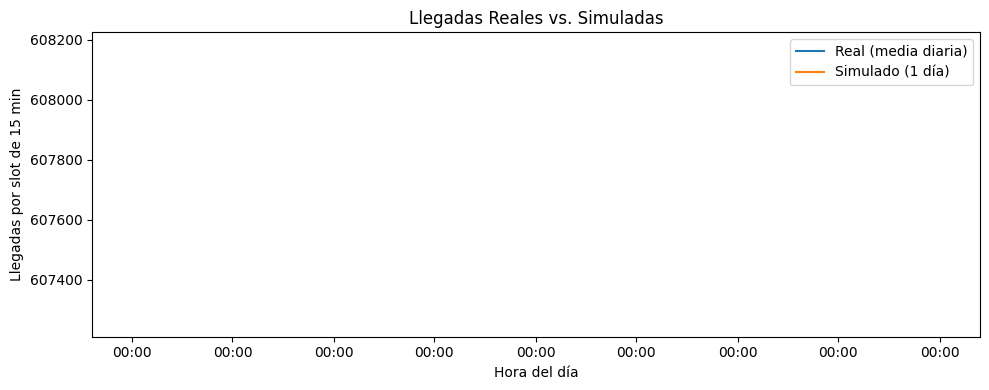

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

n_days   = df.index.normalize().nunique()
df['slot'] = df.index.floor('15T').time

real_slot = (
    df[df['is_arrival']]
    .groupby('slot')
    .size()           
    .div(n_days)            
    .rename('Real')
)


sim_slots = [
    ts.floor('15T').time()
    for ts in arrivals_day
]
sim_slot = (
    pd.Series(1, index=sim_slots)
      .groupby(level=0)
      .size()
      .rename('Simulado')
)

all_slots = sorted(set(real_slot.index) | set(sim_slot.index))
df_plot   = pd.concat([real_slot, sim_slot], axis=1) \
                .reindex(all_slots, fill_value=0)


times = pd.to_datetime([str(s) for s in df_plot.index], format='%H:%M:%S')

plt.figure(figsize=(10,4))
plt.plot(times, df_plot['Real'],    label='Real (media diaria)')
plt.plot(times, df_plot['Simulado'],label='Simulado (1 día)')
plt.gca().xaxis.set_major_formatter(
    plt.matplotlib.dates.DateFormatter('%H:%M')
)
plt.xlabel('Hora del día')
plt.ylabel('Llegadas por slot de 15 min')
plt.title('Llegadas Reales vs. Simuladas')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

from scipy.stats import ks_2samp, expon, kstest
real_ia = df[df['is_arrival']].index.to_series() \
               .diff().dropna().dt.total_seconds().values
sim_ia  = np.diff(sorted([ts.timestamp() for ts in llegadas_sim]))

lambda_real = 1/real_ia.mean()
ks_r, p_r   = kstest(real_ia, 'expon', args=(0, 1/lambda_real))
lambda_sim  = 1/sim_ia.mean()
ks_s, p_s   = kstest(sim_ia,  'expon', args=(0, 1/lambda_sim))

print(f"KS real vs Expon: estat={ks_r:.3f}, p={p_r:.3f}")
print(f"KS sim  vs Expon: estat={ks_s:.3f}, p={p_s:.3f}")

ks_rs, p_rs = ks_2samp(real_ia, sim_ia)
print(f"KS real vs sim: estat={ks_rs:.3f}, p={p_rs:.3f}")


KS real vs Expon: estat=1.000, p=0.000
KS sim  vs Expon: estat=0.001, p=0.541
KS real vs sim: estat=1.000, p=0.000


# Fase 4: Experimentación de escenarios
## Diseño de experimentos
## Ejecución de escenarios

# Fase 5: Análisis y recomendaciones
## Análisis comparativo
## Elaboración de recomandaciones